Found an easy to use sparse GP package. Gonna try that against some of this data for the lulz. 

In [1]:
from pearce.emulator import OriginalRecipe, ExtraCrispy, SpicyBuffalo
from pearce.mocks import cat_dict
import numpy as np
from os import path

/u/ki/swmclau2/.conda/envs/hodemulator/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
import matplotlib
#matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [3]:
training_file = '/u/ki/swmclau2/des/xi_cosmo_trainer/PearceRedMagicXiCosmoFixedNd.hdf5'
test_file = '/u/ki/swmclau2/des/xi_cosmo_tester/PearceRedMagicXiCosmoFixedNd_test.hdf5'
em_method = 'gp'
split_method = 'random'

In [4]:
a = 1.0
z = 1.0/a - 1.0

In [5]:
fixed_params = {'z':z, 'r':24.06822623}

In [6]:
emu = OriginalRecipe(training_file, method = em_method, fixed_params=fixed_params,\
                     custom_mean_function = 'linear', downsample_factor=0.05)#,
                    #hyperparams = {'n_estimators': 500,
                    #              'max_depth': 5})

no nans


In [8]:
N_points = int(emu.x.shape[0]*0.25)
x, y = emu.x[:N_points], emu.y[:N_points]

In [10]:
import GPy

In [13]:
y = y.reshape((-1, 1))

In [47]:
from GPy.kern import RBF, Matern52, DomainKernel

In [43]:
v = [ 12. ,         12. ,         12.  ,        12.   ,       12.     ,     12.,
  11.67920429 ,  6.81656135 , 12.   ,        1.92715272 , 12.    ,       7.72884642,
  12.,        -12.     ,      2.57697301,  12. ,          8.85016763,
   9.96558899 ,  6.24704116 , 12.      ,    12.   ,      -12.    ,     -12. ,        -12.,
  12.,       ]

#[-2.30321746, -6.,          2.74986581, -0.59132415,  0.74564814, -1.47243557,
#5.38958859,  2.36982126,  5.35110678,  1.6798139,   6.,          2.82272942,
#6.        ]

#[ 6.         -6.         -2.95890662 -6.         -3.63039154  6.
# -0.93930637 -6.         -6.          2.2162459   6.          2.75175138
#  5.09211467]

In [53]:
print len(v[2:2+emu.emulator_ndim]),  len(v[2+emu.emulator_ndim:])

11 12


In [57]:
kernel = RBF(emu.emulator_ndim,variance = v[0], lengthscale=v[2:2+emu.emulator_ndim], ARD = True)\
+Matern52(emu.emulator_ndim,variance = v[1], lengthscale=v[3+emu.emulator_ndim:], ARD = True)
#+DomainKernel(emu.emulator_ndim, -10, 10, variance = v[2], ARD= True)

In [ ]:
N_inducing = 10000
Z = np.random.rand(N_inducing,emu.emulator_ndim)*6-3
m = GPy.models.SparseGPRegression(x,y,Z=Z, kernel = kernel)
#m.likelihood.variance = noise_var
#m.plot()
print m

In [ ]:
pred_y = m.predict(emu.x[N_points:N_points+100])[0][:,0]
true_y = emu.y[N_points:N_points+100].reshape((-1, 1))[:,0]

mfap = emu.mean_function(emu.x[N_points:N_points+100])

pred_y = 10**(pred_y+mfap)
true_y = 10**(pred_y+mfap)

print (np.abs(pred_y-true_y)/np.abs(true_y)).mean()

In [50]:
if hasattr(emu, "_emulator"):
    emu._emulator.set_parameter_vector(v)
    emu._emulator.recompute()
else:
    for _emulator in emu._emulators:
        _emulator.set_parameter_vector(v)
        _emulator.recompute()

In [51]:
params = {}
for pname in emu.get_param_names():
    if pname == 'r':
        continue
    low, high = emu.get_param_bounds(pname)
    params[pname] = np.random.uniform(low, high)
    
print params

{'logM1': 14.51531762185251, 'Neff': 3.9786658142720666, 'logM0': 14.679868709368705, 'sigma_logM': 0.2120687777701265, 'H0': 73.09413658103344, 'w0': -0.7875947831281077, 'omch2': 0.11289794960708908, 'ln10As': 3.0978017751470057, 'alpha': 1.020368132273719, 'ns': 0.9687851568345146, 'ombh2': 0.023391673475508155}


In [52]:
pred_y = emu.emulate(params)[0]
print pred_y

0.9221206640568189


In [53]:
gof = emu.goodness_of_fit(training_file, N = 1000, statistic = 'log_frac')
print gof.mean()

0.10832378788059231


In [54]:
gof = emu.goodness_of_fit(test_file, statistic = 'log_frac')
print gof.mean(), np.median(gof)

0.2440002055819603 0.005182531848282994


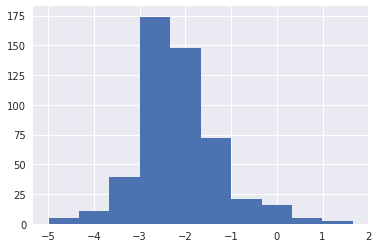

In [58]:
plt.hist(np.log10(gof));

(array([   17.,   122.,   456.,  1537.,  5569., 11217.,  7428.,  1018.,
          121.,    15.]),
 array([-1.64678463, -1.34558619, -1.04438774, -0.74318929, -0.44199084,
        -0.14079239,  0.16040606,  0.46160451,  0.76280296,  1.06400141,
         1.36519986]),
 <a list of 10 Patch objects>)

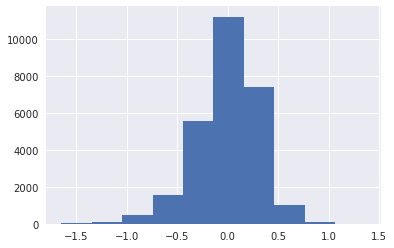

In [55]:
plt.hist(emu.y)

In [56]:
for i in xrange(50):    
    params = {}

    for pname in emu.get_param_names():
        if pname == 'r':
            continue
        low, high = emu.get_param_bounds(pname)
        params[pname] = np.random.uniform(low, high)
    pred_y = emu.emulate(params)[0]
    print pred_y
    #print params

3.4454320425730685
2.727731180610566
2.683599436729679
2.8330916204261203
-1.0369606462576912
-1.032873062107365
-0.5995028870874513
2.783170253392655
0.4382639419372183
0.8814941015821012
2.022362026791592
0.7566433646223223
2.401774288983641
4.0932008651982565
0.9482300563909412
4.037670006726215
1.478405028455529
2.4351463717002746
3.1154727614160733
1.2700564776833425
4.069131098122216
1.9391641051804602
3.875498136607006
1.092198155204005
0.9583216151524976
1.3947532135690257
1.3653945018261422
2.8781038344809824
2.5335817534066902
1.2264645546897208
1.1179109631290858
1.9170978751305945
3.2637568844687728
3.251440767066018
3.668387214883319
-0.1837988280351479
0.0006281971185209123
2.334932555778173
2.9206558237337417
4.123442015384479
-0.5773115353167981
3.276022704009547
-0.6932476331217532
2.852176565133805
1.1446459018737896
2.048020038671494
2.99737259020812
1.0972404090357395
3.841137992012656
0.7632214557529411


In [40]:
for i, (g, r) in enumerate(zip(gof, emu.scale_bin_centers)):
    print r, g.mean(), np.median(g)
    #plt.hist(np.log10(g))
    #plt.show()

0.095817335 0.013014793301090372 0.013014793301090372
0.135345585 0.010365488138659194 0.010365488138659194
0.191180715 0.006251972162426474 0.006251972162426474
0.27004994000000004 0.009509933306915689 0.009509933306915689
0.38145568 0.013776766438861656 0.013776766438861656
0.538820465 0.00012918819939269834 0.00012918819939269834
0.76110414 0.02300930049144846 0.02300930049144846
1.075088175 0.0062341800222195255 0.0062341800222195255
1.51860241 0.02082748608365456 0.02082748608365456
2.14508292 0.007070119043139359 0.007070119043139359
3.03001016 0.023751857041176605 0.023751857041176605
4.2800031149999995 0.005873088783594157 0.005873088783594157
6.04566509 0.007245859531118654 0.007245859531118654
8.53972892 0.012792893441381927 0.012792893441381927
12.062687725 0.018472815995211563 0.018472815995211563
17.0389993 0.08734021313226875 0.08734021313226875
24.06822623 0.010715074080084902 0.010715074080084902
33.997273185 0.011203846201528814 0.011203846201528814


In [41]:
n_cosmo_params = 7
loo_cosmo = emu.x[0, 0,  :n_cosmo_params]

loo_cosmo_idxs = np.all(emu.x[:, :,:n_cosmo_params] == loo_cosmo, axis =2)
train_x, train_y, train_yerr = emu.x[~loo_cosmo_idxs, :], emu.y[ ~loo_cosmo_idxs], emu.yerr[ ~loo_cosmo_idxs]
test_x, test_y, test_yerr = emu.x[loo_cosmo_idxs, :], emu.y[loo_cosmo_idxs], emu.yerr[loo_cosmo_idxs]

IndexError: too many indices for array

In [ ]:
model = emu._emulator
model.compute(train_x, train_yerr)

In [ ]:
pred_y = model.predict(train_y, test_x, False, False, False)*emu._y_std + emu._y_mean


In [ ]:
np.mean(np.abs((pred_y-test_y)/test_y))
#np.mean(np.abs((pred_y-train_y)/train_y))

In [ ]:
resids = np.abs(emu.y*emu._y_std+emu._y_mean - ypred)

In [ ]:
np.mean(resids/(emu.y*emu._y_std+emu._y_mean))

In [ ]:
ypred.mean(), emu._y_mean

In [ ]:
test_gof = emu.goodness_of_fit(test_file, statistic = 'log_frac')
print test_gof.mean()

In [ ]:
test_gof = emu.goodness_of_fit(test_file, statistic = 'frac')
print test_gof.mean()

In [ ]:
plt.hist(np.log10(test_gof));

In [ ]:
test_x

In [ ]:
(emu.x*emu._x_std) + emu._x_mean

In [ ]:
emu.get_param_names()

In [ ]:
test_x_white, test_y_white = (test_x - emu._x_mean)/(emu._x_std + 1e-5), (test_y - emu._y_mean)/(emu._y_std + 1e-5)

In [ ]:
model = emu._emulator

In [ ]:
pred_y_white = model.predict(emu.y, test_x_white, False, False, False)

In [ ]:
pred_y = pred_y_white*emu._y_std + emu._y_mean

In [ ]:
plt.plot(pred_y[:100], label = 'pred')
plt.plot(test_y[:100], label = 'truth')

plt.legend(loc = 'best')

In [ ]:
test_y.mean(), emu._y_mean, pred_y.mean()

In [ ]:
test_y.std(), emu._y_std, pred_y.std()

In [ ]:
plt.hist(pred_y_white, bins = np.linspace(-3, 3, 100), label = 'Pred')
plt.hist(test_y_white, bins = np.linspace(-3, 3, 100), label = 'Test', alpha = 0.4);
plt.legend(loc = 'best')